# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

## Data Description
The dataset is stored in file /datasets/insurance_us.csv.
- Features: insured person's gender, age, salary, and number of family members.
- Target: number of insurance benefits received by an insured person over the last five years.

# Data Preprocessing & Exploration

## Initialization

In [61]:
pip install scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [132]:
pip install imblearn

     |████████████████████████████████| 189 kB 4.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [133]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn.preprocessing import MaxAbsScaler

import math
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [134]:
insurance_full = pd.read_csv('https://code.s3.yandex.net/datasets/insurance_us.csv')

In [135]:
#Make all column names lowercase.
insurance_full.columns = insurance_full.columns.str.lower()

In [136]:
#Print data info to check for missing values.
insurance_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   salary              5000 non-null   float64
 3   family members      5000 non-null   int64  
 4   insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


As can be seen, there are no missing values in the dataset, so we do not need to worry about filling NaNs. That being said, we see that 'age' is of the float64 data type. We find this odd and will, therefore, change the data type to 'int', which is more familiar when working with age values.

In [137]:
# Use astype() to change the data type for 'age'.
insurance_full['age'] = insurance_full['age'].astype('int64')

In [138]:
# Print the number of duplicates.
print(f'This dataset contains {insurance_full.duplicated().sum()} duplicates.')

# Drop duplicates and reset index.
insurance_full = insurance_full.drop_duplicates().reset_index(drop=True)

This dataset contains 153 duplicates.


In [140]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?
print("Descriptive statistics for dataset:")
display(insurance_full.describe())

Descriptive statistics for dataset:


,gender,age,salary,family members,insurance benefits
count,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000
mean,0.498453,31.023932,39895.811842,1.203425,0.152259
std,0.500049,8.487995,9972.953985,1.098664,0.468934
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33200.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


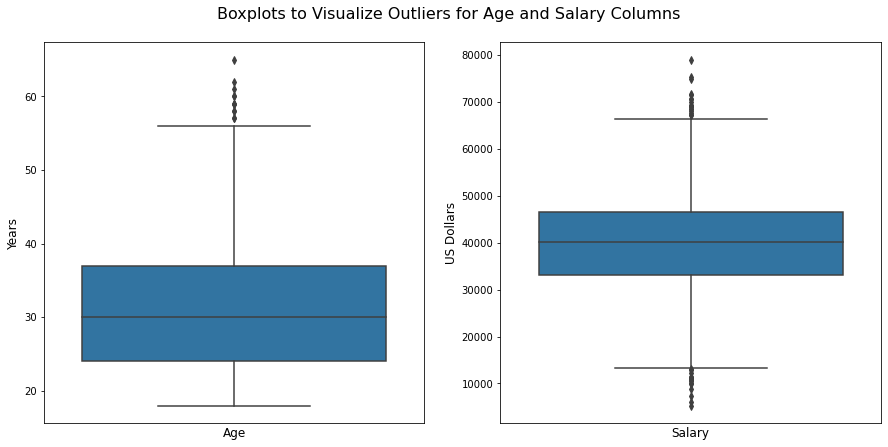

In [141]:
# Create boxplot to visualize outliers for continuous variables.
plot_columns = {'age' : 'Years', 'salary' : 'US Dollars'}

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle("Boxplots to Visualize Outliers for Age and Salary Columns", fontsize=16, y=.95)

for column in list(plot_columns):
    axs_index = list(plot_columns.keys()).index(column)
    sns.boxplot(data=insurance_full[column], ax=axs[axs_index])
    axs[axs_index].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axs[axs_index].set_xlabel(column.capitalize(), fontsize=12)
    axs[axs_index].set_ylabel(plot_columns[column], fontsize=12)
plt.show()

As we can see, there are clear outliers in the 'salary' and 'age' columns, though not very many. As we visualize the range of values for each column using a standard boxplot, we know that the outliers are identified using the 1.5 * IRQ rule - that is, any values that are 1.5 times the interquartile range above and below the 3rd and 1st quartiles, respectively, are considered outliers. We will remove these outliers from our dataset in the next subsection.

##### Remove Outliers

In [142]:
#Get interquartile range values for the 'age' and 'salary' columns. 
def remove_outliers(df, column):
    iqr = st.iqr(df[column])
    q1, q3 = np.quantile(df[column], [.25, .75])
    df = df.loc[(df[column] >= q1 - (1.5 * iqr)) & (df[column] <= q3 + (1.5 * iqr))]
    return df

# Print length of dataset prior to removing outliers.
print(f'Length of dataset before ourliers are removed: {len(insurance_full)}')

#Remove outliers from each column.
insurance_full = remove_outliers(insurance_full, 'salary')
insurance_full = remove_outliers(insurance_full, 'age')

# Print length out dataset now that outliers are removed.
print(f'Length of dataset after ourliers are removed: {len(insurance_full)}')

Length of dataset before ourliers are removed: 4847
Length of dataset after ourliers are removed: 4801


##### Split Data into Features and Target Datasets

In [143]:
# Create a list of feature columns.
features = ['gender', 'age', 'salary', 'family members']

#Create dataset for features and target.
insurance_features = insurance_full[features]
insurance_target = insurance_full['insurance benefits']

### Data Preprocessing Summary
In this subsection, we carried out the following data preprocessing steps:

1) Formatted column names to all lowercase.
2) Checked for missing values.
3) Changed the data type for the 'age' column to int64.
4) Checked for, and dropped, duplicates.
5) Checked for, and removed, outliers.
6) Split the data into features and target datasets.

Whereas our initial dataset contained 5,000 observations, our new datasets contain 4801 observations each. This means that a little less than 2.5% of our observations were dropped, which is acceptable amount, especially considering the number of observations we have to work with.

In the next section, we will use use select one customer at random and find their 5 nearest neighbors. We will then attempt to cluster individuals and find the optimum number of clusters to reduce cluster inertia. For these tasks, we will be working with the full dataset, as these tasks do not involve supervised learning.

## Find Nearest Neighbors and Clusters
### Identify Nearest Neighbors
#### Check Affect on Neighbors' Distances from Scaling and Metric

In [144]:
#Create dictionary to save distance values.
distances = {}

#Get index for random row.
np.random.seed(12345)
random_int = np.random.randint(0, len(insurance_full))

#Create function to calculate average neighbors' distances based on metric and scale.
def neighbor_dist(scaling, metric, n, k):
    df = insurance_full
    if scaling == True:
        scaler = MaxAbsScaler().fit(df)
        df = scaler.transform(df)
    else:
        df = df.values
    neighbors_func = sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric=metric)
    neighbors_func.fit(df)
    dist, nbrs = neighbors_func.kneighbors([df[n]], k, return_distance=True)
    return (np.sum(dist) / (k-1)).round(3)
    
#Save average distance measurements to dictionary, along with relevant parameter values.
distances['Scaled, Euclidean'] = neighbor_dist(True, 'euclidean', random_int, 6)
distances['Not Scaled, Euclidean'] = neighbor_dist(False, 'euclidean', random_int, 6)
distances['Scaled, Manhattan'] = neighbor_dist(True, 'manhattan', random_int, 6)
distances['Not Scaled, Manhattan'] = neighbor_dist(False, 'manhattan', random_int, 6)

#Dislpay dataframe with average distance measurements.
display(pd.DataFrame([distances], columns=distances.keys(), index=['Average Neighbors\' Distances']))

,"Scaled, Euclidean","Not Scaled, Euclidean","Scaled, Manhattan","Not Scaled, Manhattan"
Average Neighbors' Distances,0.049,16.757,0.063,20.0


In this subsection we wanted to answer the question "how does scaling and metric choice affect the average distance for 5 nearest neighbors". To do so, we made a function that takes the following arguments:

* scaling - Based on whether the value is true or not, the function will use an instance of MaxAbsScaler on the data.

* metric - This allows us to chose distance metric we would like to use with the NearestNeighbors algorithm.

* n - This represents a randomly selected index for an observation we would like to find the nearest neighbors of.

* k - This is the number of neighbors we are looking for. The number is one more than the value we use as the denominator when finding the average distance, as the NearestNeighbors algorithm will return a distance of 0 as the first value, which represents the distance between the randomly selected observation and itself. To ensure we find the average distance for 5 nearest neighbors, we pass 6 as the argument and then divide the sum of the returned distances by 5.

Based on the measurements, we can clearly see that the average distances when the data is unscaled is much greater than their scaled counterparts. This is expected, as NearestNeighbors is a distance-based algorithm; the smaller the magnitude of the values, the smaller the distances. In regards to the metrics used, the averages for distances returned for Manhattan measurements are greater than the averages returned for Euclidean measurements. This is expected, as a Manhattan distance can never be shorter than an associated Euclidean distance. This is due to triangle inequality, which states that the sum of the lengths of any two sides of a triangle must be greater than or equal to the remaining side.

So, as we can see, both metric choice and whether data is scaled has a great affect on the distances returned by the NearestNeighbors algorithm. In the following subsection, we will find the 5 nearest neighbors to our randomly selected observation. In doing so, we will standardize our data and annotate every step of finding the 5 nearest neighbors to our observation.

#### Scale Data

In [145]:
#Create StandardScaler instance.
scaler = sklearn.preprocessing.StandardScaler()

#Fit the scaler to the dataset and scale data.
insurance_full_scaled = scaler.fit_transform(insurance_full)

#Create DataFrame from scaled data.
insurance_full_scaled_df = pd.DataFrame(insurance_full_scaled, columns=insurance_full.columns)

In this subsection we scaled our full dataset. This is necessary because distance based algorithms do not function as intended when features have different value magnitudes.
#### Select Random Array

In [146]:
#Get number of rows in scaled array.
array_rows = insurance_full_scaled.shape[0]

#Obtain array based on random integer.
random_array_selected = insurance_full_scaled[random_int, :]

#Get array with randomly selected row dropped.
neighbors_array = np.delete(insurance_full_scaled, random_int, 0)

#### Find Nearest Neighbors

In [147]:
#Create NearestNeighbors instance.
neighbors = sklearn.neighbors.NearestNeighbors(n_neighbors=5)

#Fit the model.
neighbors.fit(neighbors_array)

#Find nearest neighbors for randomly selected individual.
neighbors = neighbors.kneighbors([random_array_selected], 5, return_distance=False)

#Create dataframe from neighbor values.
neighbors_df = pd.DataFrame(neighbors_array[tuple(neighbors)], columns=insurance_full.columns)

#Create DataFrame with nearest neighbor values for comparisson.
full_knn_df = pd.concat([pd.DataFrame([random_array_selected], columns=insurance_full.columns), neighbors_df]).reset_index(drop=True)

print(f'DataFrame with values for nearest neighbors of observation {random_int} (presented as index 0):')
display(full_knn_df)

DataFrame with values for nearest neighbors of observation 4578 (presented as index 0):


,gender,age,salary,family members,insurance benefits
0,1.004384,2.512461,-0.073675,-0.185927,4.289717
1,1.004384,2.393155,0.060746,-0.185927,4.289717
2,1.004384,2.273848,0.122787,-0.185927,4.289717
3,1.004384,2.154542,-0.177076,-0.185927,4.289717
4,1.004384,2.154542,0.050406,-0.185927,4.289717
5,1.004384,2.154542,-0.290818,-0.185927,4.289717


#### Nearest Neighbors Conclusion
In this subsection we created an instance of sklearn's NearestNeighbors class and used it to find the 5 nearest neighbors to a randomly selected individual from our dataset. In order to carry out this task, we first had to standardize our data, since NearestNeighbors is a distance-based algorithm. We then randomly selected one row from the standardized nested array and deleted that row from the scaled array; this was necessary in order to avoid the algorithm selecting the randomly-selected array as one of the nearest neighbors. Finally, we used the scaled array to fit the NearestNeighbors algorithm and obtained the array indices for the 5 nearest neighbors. We obtained the relevant values from our neighbors array and displayed them along with the randomly selected array's values.

As we can see, the nearest neighbors to our randomly selected individual share the same value for insurance benefits, family members, and gender. Interestingly, they all appear to have relatively high values for age - we say relatively high because our data is standardized, as a result of which the mean age is 0 and the standard deviation is 1. As such, it appears that our randomly selected individual's age is more than two standard deviations above the mean, and the same can be said for all nearest neighbors. Based on this information, we can intuitively see how these individuals may be clustered together.

In this following subsection, we will attempt to find the optimal number of clusters in which to fit all individuals.

### Cluster Individuals
#### Find Optimal Cluster Value

In [148]:
#Create list to store intertia values for kmeans algorithms. 
inertias = []

#For loop to iterate through different kmeans cluster values.
for cluster in range(1, 25):
    
    #Create an instance of the KMeans class.
    kmeans = KMeans(n_clusters=cluster, init='k-means++', n_init=20)

    #Fit the estimator to the scaled dataset.
    kmeans.fit(insurance_full_scaled)

    #Append intertia values to list.
    inertias.append(kmeans.inertia_)

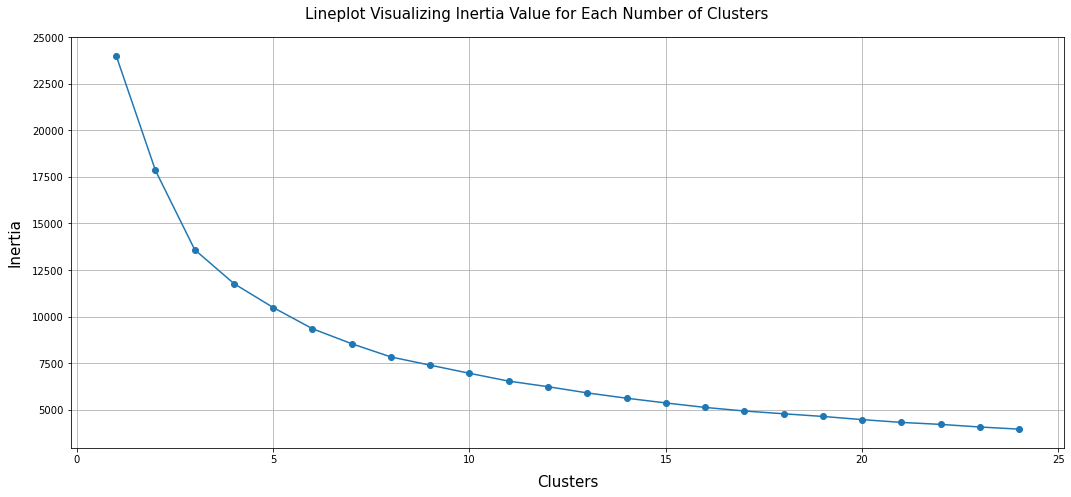

In [149]:
#Create DataFrame from inertia values in order to plot.
inertias_df = pd.DataFrame({'Inertia' : inertias}, index=range(1, 25))

#Create lineplot to visualize relation between inertia values and clusters.
fig = plt.figure(figsize=(15,7))
fig.suptitle('Lineplot Visualizing Inertia Value for Each Number of Clusters', fontsize=15)
plt.plot(inertias_df['Inertia'], marker='o')
plt.xlabel('Clusters', fontsize=15, labelpad = 10)
plt.ylabel('Inertia', fontsize=15, labelpad = 10)
plt.grid()
plt.tight_layout()
plt.show()

 In this subsection we used unsupervised learning to cluster individuals. To find the optimal number of clusters, we used a for loop to iterate through a range of cluster values and saved each model's inertia value to a list. Inertia is the sum of the distances of all points within a cluster from the center point of the cluster - ideally, one would want a low inertia value that also does not lead to unnecessarily high computational costs. To find the optimal number of clusters, we plotted the inertia value for each cluster value. It is generally accepted that the optimal number of clusters can be found from such a plot by taking the cluster value where the decrease in inertia value becomes constant. From our graph, this appears to occur around 9 clusters; as such, we will use 9 as the cluster value for this task.

#### Cluster Individuals Based Using Optimal Cluster Value

In [150]:
#Create an instance of the KMeans class.
kmeans = KMeans(n_clusters=9, init='k-means++', n_init=20)

#Fit the estimator to the scaled dataset.
kmeans.fit(insurance_full_scaled)

#Obtain cluster predictions for the dataset.
pred = kmeans.predict(insurance_full_scaled)

#Create dataframe with cluster prediction for each observation.
pred_df = pd.DataFrame(insurance_full_scaled)
pred_df['Cluster'] = pred

#Obtain cluster value counts.
print("Value counts for number of observations in each cluster:")
print(pred_df['Cluster'].value_counts())

Value counts for number of observations in each cluster:
4    804
1    717
6    600
5    569
0    542
7    534
3    489
2    419
8    127
Name: Cluster, dtype: int64


#### Clustering Conclusion
In this subsection we clustered all individuals in our dataset into multiple clusters. To find the optimal number of clusters, we compared the inertia value for each cluster value in the range of 1-25. We found that the optimal value lies around 9, so we used this as the cluster number for predicting which cluster individuals in our dataset fall into. In subsection 2.2.2, we obtained value counts for each cluster; the majority of individuals appear to fall into cluster 6, and the fewest individuals fall into cluster 8.

We believe that organizing individuals into clusters would be a worthwhile endeavor for Sure Tomorrow, as it would allow them to provide more targeted solutions to their clients. To determine exactly what sorts of solutions should be provided based on the clusters we created, analysts would have to carry out exploratory data analysis on the results of our clustering. Since this project is geared more towards building models to predict whether a client is likely to receive an insurance benefit and how many insurance benefits a client is likely to receive, we will not look into these clusters any further; our goal in this section was simply to see whether we would be able to cluster clients, and what number of clusters would be optimal.

In the following section, we will build a model with the goal of determining whether a new customer is likely to receive an insurance benefit.

## Build Model to Predict Insurance Benefit Recipients
In this section, we will attempt to build a model to classify individuals according to whether they are likely to receive an insurance payout. In order to do so, we will check for class imbalances, split the data into training and testing dataset, train our models, determine whether we should move our classification threshold, test our best model, and, finally, determine whether our model performs better than a dummy model.

#### Check for Class Imbalance

In [151]:
#Since this is a binary classification task, create Series with 1's and 0's based on whether individual received insurance benefit.
insurance_target_classification = insurance_target.apply(lambda x: 0 if x==0 else 1)

#Print value count to check for class imbalance.
print("Value count of target variable:")
print(insurance_target_classification.value_counts())

Value count of target variable:
0    4254
1     547
Name: insurance benefits, dtype: int64


As we can see, there is a significant class imbalance between those who haven't received insurance benefits and those who have. As such, we will need to balance the classes in order to properly train a model. In a later subsection, we will balance the classes by using SMOTE (Synthetic Minority Over-sampling Technique)on training folds. SMOTE balances classes by oversampling using synthetically generated observations based on nearest neighbors.

#### Split Data into Training and Testing Datasets

In [152]:
#Split the data into training and testing datasets.
#Use stratified parameter to get equal proportion of positives in the training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(insurance_features, insurance_target_classification, test_size=.3, stratify=insurance_target_classification)

## Create Class with Pipeline for Determining Best Classification Model

In [153]:
#Create class to find best models while using a pipeline to transform data.
class pipeline_model:
    
    #Initialize model with required variables.
    def __init__(self, model, params, name):
        self.model = model
        self.params = params
        self.name = name
        self.f1 = None
        self.test_score = None
        self.best_params = None
        self.confusion = None
    
    #Build function to use pipeline in finding best model with GridSearchCV.
    def pipe(self, scale):
        
        #Check whether or not to scale the data.
        if scale == True:
            #Use SMOTE and Scaler for training folds.
            pipeline = Pipeline(steps=[['smote', SMOTE(random_state=12345)], 
                              ['scaler', sklearn.preprocessing.StandardScaler()], 
                               ['classifier', self.model]])
        else:
            pipeline = Pipeline(steps=[['smote', SMOTE(random_state=12345)], 
                               ['classifier', self.model]])
        
        #Create stratified folds for GridSearch.
        strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

        #Use GridSearchCV to tune hyperparameters.    
        grid_search = GridSearchCV(estimator=pipeline, param_grid=self.params, scoring='f1', cv=strat_kfold, \
                           n_jobs=-1, verbose = 0, refit=True)
        
        #Fit best model and obtain relevant values.
        grid_search.fit(X_train, y_train)
        self.f1 = grid_search.best_score_
        self.test_score = grid_search.score(X_test, y_test)
        self.best_params = grid_search.best_params_
        self.confusion = confusion_matrix(y_test, grid_search.predict(X_test))
    
    #Build function to plot confusion matrix.
    def plot(self):
        fig = plt.figure(figsize=(13, 7))
        sns.heatmap(self.confusion, annot=True, fmt='g', cmap='Greens')
        
        # labels, title and ticks
        plt.title(f'Confusion Matrix for {self.name}', fontsize=15)
        plt.xlabel('Predicted labels', fontsize=12)
        plt.ylabel('True labels', fontsize=12)
        plt.show()

In this subsection we built a class that will allow us to create classification objects which will store each model's name, best parameters, scores, and confusion matrix data. This class was built to simplify testing different models with GridSearchCV while also transforming training data using a pipeline. The function pipe() takes the defined model and parameters and creates a GridSearchCV object. GridSearchCV carries out cross validation on 5 stratified folds and fits/transforms the training datasets using SMOTE and StandardScaler.

The model with the optimal hyperparameters is judged based on its F1 score. F1 is a harmonic mean between precision and recall; the optimal F1 value is 1. Since 'refit' is set to true in GridSearchCV, each object's model will be fit to the best parameters. We obtain the F1 score from the refit model using the testing dataset and save it as a variable; we also save the models best parameters, the F1 score for the training data, and the model's confusion matrix. Note, while SMOTE is a part of the pipeline, it is only applied when fitting data; as such, our testing dataset is not SMOTEd when we call .score().

In the following subsection, we will create multiple pipeline_model objects and use each one to train and test a specific classification algorithm.

#### Train and Test Classification Models

In [154]:
#Create dictionary to store each model's name and test score.
dict_training_scores = {}
dict_test_scores = {}

#Train and test LogisticRegression model.
pipe_reg = pipeline_model(LogisticRegression(random_state=12345), 
                          {'classifier__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                           'classifier__max_iter' : range(400, 1000, 50)}, "Logistic Regression")

pipe_reg.pipe(True)
dict_test_scores[pipe_reg.name] = pipe_reg.test_score.round(2)
dict_training_scores[pipe_reg.name] = pipe_reg.f1.round(2)

In [155]:
#Train and test SVC model.
pipe_svc = pipeline_model(SVC(random_state=12345),
                         {'classifier__kernel' : ['linear', 'rbf', 'sigmoid'],
                         'classifier__gamma' : [.1, 1, 10, 20],
                         'classifier__C' : [.1, 1, 10, 100, 150]}, "SVC")

pipe_svc.pipe(True)
dict_test_scores[pipe_svc.name] = pipe_svc.test_score.round(2)
dict_training_scores[pipe_svc.name] = pipe_svc.f1.round(2)

In [156]:
#Train and test DecisionTreeClassifier model.
pipe_tree = pipeline_model(DecisionTreeClassifier(random_state=12345), {'classifier__max_depth': range(5, 10, 5), \
                       'classifier__min_impurity_decrease' : np.arange(.01, .20, .02), \
                       'classifier__min_samples_split' : range(1, 10, 2)}, 'Decision Tree')

pipe_tree.pipe(True)
dict_test_scores[pipe_tree.name] = pipe_tree.test_score.round(2)
dict_training_scores[pipe_tree.name] = pipe_tree.f1.round(2)

In [157]:
#Train and test KNeighborsClassifier model.
pipe_KNN = pipeline_model(KNeighborsClassifier(), {'classifier__n_neighbors': range(3, 15, 1), \
                       'classifier__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], \
                       'classifier__leaf_size' : range(10, 80, 10)}, 'KNN')

pipe_KNN.pipe(True)
dict_test_scores[pipe_KNN.name] = pipe_KNN.test_score.round(2)
dict_training_scores[pipe_KNN.name] = pipe_KNN.f1.round(2)

In [158]:
#Train and test RandomForestClassifier model.
pipe_forest = pipeline_model(RandomForestClassifier(random_state=12345), {'classifier__n_estimators' : range(10, 100, 10),
                            'classifier__max_depth' : range(5, 30, 5), 'classifier__min_impurity_decrease' : np.arange(.01, .2, .02)},
                            'Random Forest')

pipe_forest.pipe(True)
dict_test_scores[pipe_forest.name] = pipe_forest.test_score.round(2)
dict_training_scores[pipe_forest.name] = pipe_forest.f1.round(2)

In [159]:
#display(pd.DataFrame([[dict_final_scores, dict_test_scores]], columns=dict_final_scores.keys(), index=['F1 Score']))
classification_scores_df = pd.DataFrame.from_dict(dict_test_scores, orient='index', columns=['F1 Test'])
classification_scores_df['F1 Training'] = dict_training_scores.values()

In [160]:
print("F1 scores for all models (testing and training datasets)")
display(classification_scores_df)

F1 scores for all models (testing and training datasets)


,F1 Test,F1 Training
Logistic Regression,0.92,0.93
SVC,1.00,1.00
Decision Tree,0.96,0.97
KNN,0.91,0.92
Random Forest,0.96,0.97


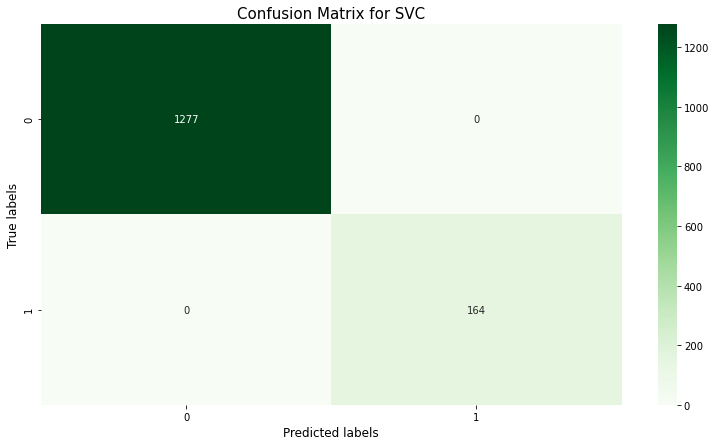

In [161]:
#Plot confuction matrix for SVC model.
pipe_svc.plot()

 In this subsection we created 5 instances of pipeline_model, each with a different classification model and relevant hyperparameters to iterate through. We appended the best scores for each model on the training dataset, as well as the final scores for each model on the testing dataset, to two dictionaries. We finally created a DataFrame for the scores and displayed them.

As we can see, the F1 scores for each model are quite high, and there is little difference between each model's training score and testing score. The latter may be due to SMOTING only being carried out on the training datasets during GridSearchCV's execution and not on the validation set - this helps to prevent data leakage and usually results in testing and training scores quite close to one another. Due to the high values of the scores, we were skeptical at first and tried to determine whether our models were overfit; however, after much research and scrutiny, we have concluded that our models are simply well trained.

Overall, the SVC model had the best F1 score - as a matter of fact, it's perfect, meaning that it accurately classified all observations based on whether or not an individual received an insurance benefit. The precision and recall for this model on the testing dataset can be seen in the above confusion matrix.

In the following subsection, we will have a closer look at the KNearestNeighbors model and examine how scaling and the number of neighbors considered affects the models F1 score.

## Test Variations of KNN Model

In [162]:
#Create lists for F1 scores for scaled and unscaled data.
KNN_scores_unscaled = []
KNN_scores_scaled = []

#Iterate through a range of values for the n_neighbors hyperparameter.
for i in range(1, 51, 1):
    #Train and test KNeighborsClassifier model.
    pipe_KNN2 = pipeline_model(KNeighborsClassifier(), {'classifier__n_neighbors': [i], \
                       'classifier__algorithm' : ['auto'], \
                       'classifier__leaf_size' : [10]}, 'KNN')

    #Obtain F1 score on testing dataset for unscaled data.
    pipe_KNN2.pipe(False)
    KNN_scores_unscaled.append(pipe_KNN2.test_score.round(2))
    
    #Obtain F1 score on testing dataset for scaled data.
    pipe_KNN2.pipe(True)
    KNN_scores_scaled.append(pipe_KNN2.test_score.round(2))

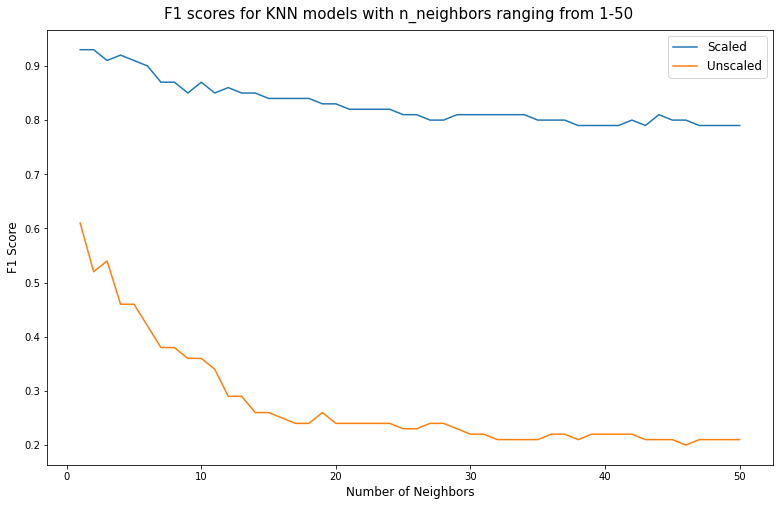

In [163]:
#Create DataFrame with F1 scores for scaled and unscaled model results.
KNN_scores_df = pd.DataFrame({'Unscaled' : KNN_scores_unscaled, 'Scaled' : KNN_scores_scaled}, index=range(1, len(KNN_scores_scaled) + 1))

#Create lineplot to visualize change of F1 scores with increasing k value.
fig = plt.figure(figsize=(13, 8))
plt.suptitle("F1 scores for KNN models with n_neighbors ranging from 1-50", fontsize=15, y=.92)
sns.lineplot(x=KNN_scores_df.index, y='Scaled', data=KNN_scores_df, label='Scaled')
sns.lineplot(x=KNN_scores_df.index, y='Unscaled', data=KNN_scores_df, label='Unscaled')
plt.xlabel('Number of Neighbors', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=12)
plt.show()

As we can see from the above scores, increasing the number of neighbors considered when training a model appears to result in a decrease in F1 score - this is likely the result of introducing more distance, and therefore increasing the possible error rate. It may be tempting to set the number of neighbors used to the smallest value, as we see that this leads to the highest F1 score; however, this would likely result in overfitting. We believe that the optimal number of neighbors, in this case, should be chosen based on the rate of change of the F1 score for each neighbor in the graph.

We can also see in this graph that the F1 scores for unscaled data are substantially worse than their scaled counterpart. This has to do with the magnitude of unscaled values and the dimensionality of the dataset. Clearly, scaling feature values before training a KNN model is important for maximizing F1 scores.

### Compare Best Model Scores to Dummy Model

In [164]:
#Creat lists for probabilities and dummy scores
probabilities = []
dummy_scores = []

#Create function to return list of random predictions.
def rnd_model_predict(P, size, seed=12345):
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

#Test dummy model's F1 scores for each relevant probability of obtaining 1's.
for P in [0, insurance_target_classification.sum() / len(insurance_target_classification), 0.5, 1]:
    y_pred_rnd = rnd_model_predict(P, len(insurance_target_classification))
    probabilities.append(P)
    dummy_scores.append(f1_score(insurance_target_classification, y_pred_rnd).round(2))

display(pd.DataFrame({'Probabilities' : probabilities, 'Dummy Scores (F1)' : dummy_scores}))

,Probabilities,Dummy Scores (F1)
0,0.000000,0.00
1,0.113935,0.10
2,0.500000,0.17
3,1.000000,0.20


As we can see, our dummy model performs (at each probability of obtaining 1's) far worse than any of the 5 classification models we used. It appears that even the F1 scores for our above KNN model when the data is unscaled offers better F1 scores than the dummy model.

### Classification Conclusion
In this section we created a class that allows us to pass through an estimator and train/test models using a pipeline. This pipeline upsampled and scaled the data, the latter depending on the argument we pass through. We then passed the pipeline with the estimator through GridSearchCV and fit each model based on the optimal hyperparameters found. Overall, the model with the highest F1 score was the SVC model, which accurately classified each observation based on whether or not an individual obtained an insurance benefit.

Aside from finding an optimal model for our purposes, we also wanted to test how scaling and neighbors value affects KNN models. We found that the F1 score for a KNN model tends to decrease rapidly when increasing the value of neighbors starting at 1, but then appears to level out. We also found that scaled data provides far better F1 scores than unscaled data.

Finally, we used a dummy model to compare the F1 scores we obtained from our classification models. Our dummy model, for each probability of obtaining positive values tested, performed far worse than our classification models, which demonstrates that are models are actually adept at making accurate predictions.

In the next section, we will build a linear regression model to predict the number of insurance benefits an individual is likely to receive.

## Build Model to Predict Number of Insurance Benefits
In this section, we will build a linear regression model with the goal of determining the number of insurance benefits an individual obtains. We will evaluate our model using the RMSE (Root Mean Squared Error) metric.

### Build Class for Linear Regression

In [165]:
#Create class.
class LR:
    
    #Initialize class with relevant variable(s).
    def __init__(self):
        self.weights = None
    
    #Define function for fitting model.
    def fit(self, X, y):
        #Add 1's to first column of matrix to obtain y-intercept values.
        X2 = np.append(np.ones([len(X), 1]), X.to_numpy(), axis=1)
        #Calculate weights vector.
        self.weights = np.linalg.inv(np.dot(X2.T, X2)).dot(X2.T).dot(y.to_numpy())

    #Define model for predicting values using weights vector.
    def predict(self, X):
        #Add 1's to first column of matrix to obtain y-intercept values.
        X2 = np.append(np.ones([len(X), 1]), X.to_numpy(), axis=1)
        y_pred = X2.dot(self.weights)
        return y_pred

### Create Function to Calculate Metrics

In [166]:
#Define function to obtain RMSE and R2 values.
def eval_regressor(y_true, y_pred):
    rmse = round(math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred)), 2)
    r2_score = round(sklearn.metrics.r2_score(y_true, y_pred), 2)
    return rmse, r2_score

### Test Linear Regression Model

In [167]:
#Fit model and obtain prediction values.
lr = LR()
lr.fit(X_train, y_train)
lr_test_pred = lr.predict(X_test)

In [168]:
#Scale data and fit/test new model.
lr_scaler = sklearn.preprocessing.StandardScaler()
train_features_scaled = pd.DataFrame(lr_scaler.fit_transform(X_train), columns=X_train.columns)
test_features_scaled = pd.DataFrame(lr_scaler.transform(X_test), columns=X_test.columns)

#New instance of LR model.
lr_scaled = LR()
lr_scaled.fit(train_features_scaled, y_train)
lr_scaled_predict = lr_scaled.predict(test_features_scaled)

In [169]:
#Train and obtain predictions from sklean linear regression model for comparison.
reg = sklearn.linear_model.LinearRegression()
reg.fit(X_train.to_numpy(), y_train.to_numpy())
reg_test_predict = reg.predict(X_test)

In [170]:
#Compare scores from both models.
display(pd.DataFrame({'Self-Made (Unscaled)' : eval_regressor(y_test, lr_test_pred),
                      'Self-Made (Scaled)' : eval_regressor(y_test, reg_test_predict),
                    'Sklearn Model' : eval_regressor(y_test, reg_test_predict)}, index=['RMSE', 'R2']))

,Self-Made (Unscaled),Self-Made (Scaled),Sklearn Model
RMSE,0.24,0.24,0.24
R2,0.43,0.43,0.43


### Regression Conclusion
In this section we attempted to build our own logistic regression model. In doing so, we created a class with 'fit' and 'predict' functions. The 'fit' function appends a column of ones to the start of the training features matrix, in order to accurately calculate the y-intercept during matrix multiplication, and then calculates the weights vector. The 'predict' function appends a column of ones to the start of the testing features matrix and then multiples that matrix by the weights vector. The result is our predicted y-values.

We created a function that provides us with the RMSE and R2 scores for our model. The RMSE score represents the standard deviation of the prediction errors, and will take on a value between 0 and 1. The R2 score represents the percentage of the dependent variable that is explained by the regression model; like RMSE, R2 values will range between 0 and 1.

As we can see, our RMSE for the self-made model is approximately .24, which means that 68% of our data can be found within .24 units (measured in terms of our target's units) from the actual target value. With a relatively low RMSE score, we would expect a higher R2 score; this is exactly what we found, as our model's R2 score is approximately .42. We obtained the exact same scores for our model using the scaled data; this demonstrates that the metrics used are not sensitive to the magnitude of values used with linear regression.

We wanted to be sure that the results from our model were accurate, so we decided to build and test a model using sklearn's linear regression algorithm. As can be seen in subsection 4.3, sklearn's model provided us with the same scores as our own model; this is good news, as it demonstrates that our model functions properly.

In the next section, we will prove that data obfuscation can work with linear regression.

## Construct and Test a Data Obfuscation Algorithm
In this section we will attempt to build an algorithm that obfuscates observations in the dataset. Our aim is to build an algorithm that does not negative affect the quality of machine learning models. In order to meet this goal, we will first test obfuscating data by multiplying matrices by an invertible matrix. We will then prove analytically that data obfuscation works with linear regression. Finally, we will train and test a linear regression model with obfuscated and non-obfuscated data to demonstrate that obfuscation does not impact the model's RMSE score.

#### Test Obfuscating Data
A common way of obfuscating data in a matrix

X is to multiply the numerical features by an invertible matrix P. This results in a new matrix: X'= XP. In this subsection, we will test obfuscating the data in our training features dataset.

### Create Features and Random Matrix

In [171]:
#Create matrix from training features.
X = X_train.to_numpy()

In [172]:
#Create random number generator.
rand = np.random.default_rng(seed=12345)

#Create random matrix.
P = rand.random(size=(X.shape[1], X.shape[1]))

#### Check if Random Matrix is Invertible

In [173]:
#Check if matrix is invertible.
P_inverse = np.linalg.inv(P) 

Since no error was thrown by attempting to create the inverse of P, we can be confident that the matrix is invertible.

#### Obfuscate Features Data

In [174]:
#Multiply features matrix by random obfuscation matrix.
print(X.dot(P))

[[24767.08517686 34666.09606021  9149.64523937 34924.00775365]
 [28336.32455046 39660.39359991 10470.7748933  39955.94773226]
 [30821.49846344 43141.98903371 11383.25836228 43463.75138597]
 ...
 [22888.95876897 32034.27716236  8463.6883388  32269.24179557]
 [26381.97581039 36926.18602087  9745.27848539 37202.02226379]
 [30418.07217305 42577.22407289 11235.10829896 42895.09894954]]


#### Check if Data is Recoverable

In [175]:
#Print first 3 rows of features matrix.
print("Original features matrix:\n")
print(X[:3, :])

#Print first three rows of obfuscated matrix.
print("\nMatrix with obfuscated data:\n")
print(X.dot(P)[:3, :])

#Try to reverse obfuscation and print data.
print("\nMatrix with obfuscation reversed:\n")
print((X.dot(P)).dot(P_inverse)[:3, :])

Original features matrix:

[[0.00e+00 2.30e+01 3.68e+04 1.00e+00]
 [1.00e+00 3.00e+01 4.21e+04 2.00e+00]
 [0.00e+00 2.20e+01 4.58e+04 1.00e+00]]

Matrix with obfuscated data:

[[24767.08517686 34666.09606021  9149.64523937 34924.00775365]
 [28336.32455046 39660.39359991 10470.7748933  39955.94773226]
 [30821.49846344 43141.98903371 11383.25836228 43463.75138597]]

Matrix with obfuscation reversed:

[[ 7.27595761e-12  2.30000000e+01  3.68000000e+04  1.00000000e+00]
 [ 1.00000000e+00  3.00000000e+01  4.21000000e+04  2.00000000e+00]
 [-7.27595761e-12  2.20000000e+01  4.58000000e+04  1.00000000e+00]]


#### Obfuscation Testing Conclusion
As we can see, data obfuscation by multiplying a features matrix by an invertible matrix works. By multiplying our original matrix by the randomly generated one, we obtained a matrix which we could not discern any relevant and meaningful information from. For example, in our original matrix, the first two columns represent gender (as a binary variable) and age, respectively; after obfuscation, we are not able to infer gender or age from the same columns.

After obfuscating the data, we were able to deobfuscate it by multiplying the obfuscated matrix by the inverse of the obfuscation matrix. The values we obtained were very close to the original matrix's values, though not exactly the same - this can specifically be seen when comparing the results of the gender column. This difference of values is due to the limitations of floating point arithmetic. Because floating-point numbers are represented as base-2 binary fractions, most decimal fractions cannot be represented exactly as binary fractions; as such, most values are stored as very close approximations of the actual values. Whereas floating point arithmetic limitations may result in deobfuscated data being different than the original data, the difference would be extremely small; in most situation, such small differences are negligible.

In the following subsection, we will prove that data obfuscation works with linear regression.

## Prove that Data Obfuscation Works with Linear Regression
For this task, we assume that our data will be obfuscated by multiply our feature matrix (X) by an invertible matrix (P). Consequently, the formula used to find the ideal weights will be different from the ordinary least squares formula. Both formulas can be found below:

$$w = (X^{T}X)^{-1}X^{T}y$$ 
$$w_{p} = [(XP)^{T}XP]^{-1}(XP)^{T}y$$

For this task, we will attempt to demonstrate how the coefficient vector for the first formula relates to the second - that is, we will attempt to explain the obfuscation formula's coefficient vector in terms of the ordinary least squares formula's coefficient vector.

### Properties of Matrices
In solving
$w_{p}$ in terms of $w$, we will refer to the following properties of matrices:

1)

Distributivity: $A(B+C) = AB + AC$

2)

Non-commutativity: $AB ≠ BA$

3)

Associative property of multiplication: $(AB)C = A(BC)$

4)

Multiplicative identity property: $IA = AI = A$

4.2)

$A^{-1}A = AA^{-1} = I$

4.3)

$(AB)^{-1} = B^{-1}A^{-1}$

5)

Reversivity of the transpose of a product of matrices: $(AB)^{T} = B^{T}A^{T}$

##### Solve for $w_{p}$

We can solve for the obfuscation algorithm's coefficient vector by carrying out the following steps:

(1) Based on 5, separate the transpose matrices:

$w_{p} = [(P^{T}X^{T})XP]^{-1}P^{T}X^{T}y$

(2) From 4.3, distribute the inverse sign:

$w_{p} = [(XP)^{-1}(P^{T}X^{T})^{-1}]P^{T}X^{T}y$

(3) From 4.3, distribute the inverse sign again:

$w_{p} = [P^{-1}X^{-1}X^{T-1}P^{T-1}]P^{T}X^{T}$

(4) From 3, use associative property to reformulate:

$w_{p} = P^{-1}[X^{-1}(X^{T})^{-1}](P^{T-1})P^{T}X^{T}y$

(5) From 4.2, obtain identity matrix:

$w_{p} = P^{-1}[X^{-1}(X^{T})^{-1}]IX^{T}y$

(6) From 4, remove identity matrix:

$w_{p} = P^{-1}[X^{-1}(X^{T})^{-1}]X^{T}y$

(7) From 4.3, place invertible matrix sign outside of brackets:

$w_{p} = P^{-1}[X^{-1}X]^{-1}X^{T}y$

(8) Substitute ordinary least squares formula into new formula: $P^{-1}w$

### Investigate Affect of Obfuscation on Model
The prediction formula for linear regression may be represented as follows:

$a = Xw$

This formula differs when obfuscating. When adding the obfuscation coefficient vector and obfuscation matrix, our linear regression formula may be represented as follows:

$a' = XPwp$

We can demonstrate that obfuscation has no affect on predictions by simplifying the above formula using the following steps:

(1) Substitute

$wp$ for its value in terms of $w: a' = XPP^{-1}w$

(2) From 4.2, obtain the identity matrix:

$a' = XIw$

(3) From 4.2, remove identity matrix:

$a' = Xw$

(4) Substitute

$Xw$ for its value in terms of $a:a' = a$

As we can see, we obtain the same predictions whether or not we obfuscate the data.

### Data Obfuscation for Linear Regression Proof Conclusion
Using basic algebra and the abovementioned properties of matrices, we can see that multiplying our features matrix by an invertible matrix changes the coefficient vector by a factor of the inverse of the inverse of the invertible matrix. So, whereas

$w$ represents the coefficient vector for an ordinary least squares formula, $P^{-1}w$ represents the coefficient vector when multiplying our features matrix by the invertible matrix $P$ When examining how obfuscation affects our predictions, we find that there is no difference in predictions between an obfuscated dataset and unobfuscated dataset; as such, there is also no difference in the RMSE score of a linear regression model using unobfuscated data verses obfuscated data. In the following subsection, we will test linear regression with data obfuscation.

### Test Linear Regression with Data Obfuscation
In this subsection, we will test data obfuscation with linear regression. In doing so, we will use our previously-constructed linear regression class. We will compare linear regression metric scores between the original datasets and obfuscated datasets. We will not scale the data in this instance, as the R2 and RMSE scores for linear regression were not found to be affected by data scaling.

### Create Invertible Obfuscation Matrix

In [176]:
#Create random matrix.
P2 = rand.random(size=(X_train.to_numpy().shape[1], X_train.to_numpy().shape[1]))

#Check that obfuscation matrix is invertible.
try:
    np.linalg.inv(P2)
    print("Obfuscation matrix is invertible!")
except:
    print("Obfuscation matrix is not invertible. Try generating a new one.")

Obfuscation matrix is invertible!


### Create Function to Obfuscate Data

In [177]:
#Create subclass that allows for data obfuscation.
class LR_Obf(LR):
    #Create function to obfuscate data that works with our LR class.
    def obfuscate(self, data):
        obfs_data = pd.DataFrame(data.to_numpy().dot(P2))
        return obfs_data

### Run Linear Regression on Obfuscated and Unobfuscated Data.

In [178]:
#Create instance of LR for unobfuscated data. Fit model and get predictions.
lr_unob = LR_Obf()
lr_unob.fit(X_train, y_train)
lr_unob_predict = lr_unob.predict(X_test)

#Create instance of LR for obfuscated data. Fit model and get predictions.
lr_obf = LR_Obf()
lr_obf.fit(lr_obf.obfuscate(X_train), y_train)
lr_obf_predict = lr_obf.predict(lr_obf.obfuscate(X_test))

In [179]:
#Compare scores from both models.
display(pd.DataFrame({'Unobfuscated' : eval_regressor(y_test, lr_unob_predict),
                      'Obfuscated' : eval_regressor(y_test, lr_obf_predict)}, index=['RMSE', 'R2']))

,Unobfuscated,Obfuscated
RMSE,0.24,0.24
R2,0.43,0.43


### Linear Regression with Data Obfuscation Conclusion
As we can see, data obfuscation does not have an impact on a linear regression model's RMSE nor R2 scores. This is expected, as all values are changed by the same factor, and the RMSE and R2 metrics do not represent measurements in terms of the magnitude of values being used. RMSE represents the standard deviation of residuals and R2 represents the percentage of the dependent variable that is explained by the regression model; both metrics take on a value of between 0 and 1. Since neither metric is sensitive to the magnitude of the values being used in linear regression, changing all values by the same factor would not have an effect on the RMSE and R2 scores.

## Conclusion
The main goal of this project was to see if we can build machine learning various machine learning models for Sure Tomorrow that perform different tasks, including predicting similar customers, clustering customers, predicting whether a customer is likely to receive an insurance benefit, predicting how many insurance benefits a customer may receive, and carrying out linear regression to predict the number of insurance benefits a customer may receive while at the same time obfuscating data. The results of our project may be summarized as follows:

1) Finding Nearest Neighbors: We created an instance of sklearn's NearestNeighbors class and used it to find the 5 nearest neighbors for a randomly selected observation. In reviewing the data for the nearest neighbors we found, we noticed that the observations had the same values for certain variables. This lead us to believe that the data may be able to be clustered without much inertia.

2) Clustering Observations: We used unsupervised learning to cluster individuals and compared the number of clusters with the total inertia value. By plotting the inertia value for each number of clusters, we found that the optimal number of clusters to divide observations into is 9. When clustering individuals into 9 clusters, we found that most individuals fall into cluster 6 and fewest into cluster 8. While we did not dive deeper into the shared attributes of each cluster, we would recommend that Sure Tomorrow look deeper into clustering, as it may allow the company to target advertisements more effectively.

3) Classification: We built a class that runs data through a pipeline and trains/tests a given estimator. Overall, the model we found with the highest F1 score was the SVC model, which accurately classified each observation based on whether or not an individual obtained an insurance benefit. We also tested a KNN model and examined how scaling and the specified number of neighbors affects F1 score. We found that the F1 score tends to decrease rapidly when increasing the value of neighbors starting at 1, but then appears to level out. We also found that the F1 scores using scaled data are far higher than when using unscaled data. Finally, we examined the F1 scores we obtained for our various classification models against a dummy model that assigns the positive class using different probabilities. We found that the F1 score was far lower at each probability for our dummy model than our classification models.

4) Regression: We built a linear regression model that provides predictions regarding the number of insurance benefits an individual will receive. To evaluate our model, we used the RMSE and R2 metrics. We tested our model using scaled and unscaled data and found that the RMSE and R2 scores were the same for each, demonstrating that scaling has no affect on these metrics. We also found that the RMSE score was lower than the R2 score for our model. Finally, we created an instance of sklearn's linear regression class and tested it using the same datasets; we did this to confirm that our model functions correctly. As it turns out, we obtained the exact same scores using sklearn's algorithm.

5) Data Obfuscation: In order to see if obfuscation has any affect on a linear regression model's RMSE score, we first tested obfuscating the values of a matrix by multiplying the matrix by an invertible matrix; because the second matrix was invertible, we were able to multiply the output matrix by the inverse of the invertible matrix to obtain values extremely close to, if not exactly equal to, the values in our original matrix. The slight difference in values obtained is due to the limitations of floating point arithmetic. After testing data obfuscation, we proved analytically that data obfuscation works with linear regression and that it does not affect RMSE scores. Finally, we tested data obfuscation with a linear regression model and found that obfuscation did not have any affect on the model's RMSE or R2 score. To do this, we created a subclass of LR that allows us to selectively obfuscate data by calling the model.obfuscate() method.

In summary, we demonstrated that it is possible to build models that meet Sure Tomorrow's requirements; this includes clustering observations, predicting whether an individual is likely to receive insurance benefits and, if so, how many, and obfuscating data. We believe that Sure Tomorrow could use versions of the models tested in the project to increase revenue through targeted advertisement and selective policy pricing. Our only recommendation is that Sure Tomorrow analysts look into the clustered observations to determine which features are most determinant of which cluster an individual belongs, as well as how to use this information to increase revenue.